In [130]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt

%matplotlib inline

In [131]:
label_df = pd.read_csv("./data/labels.csv").dropna()

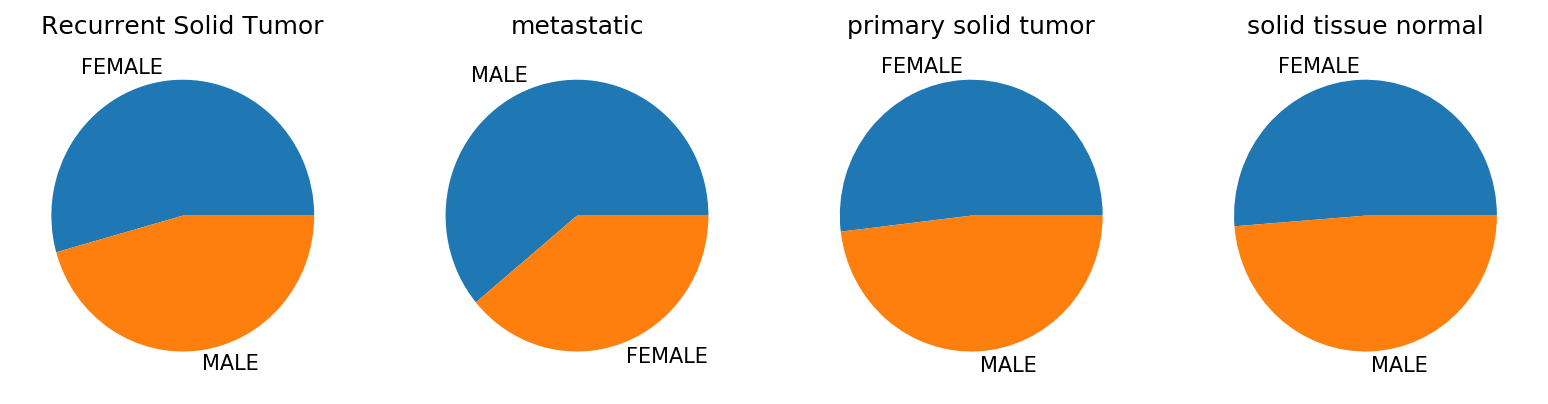

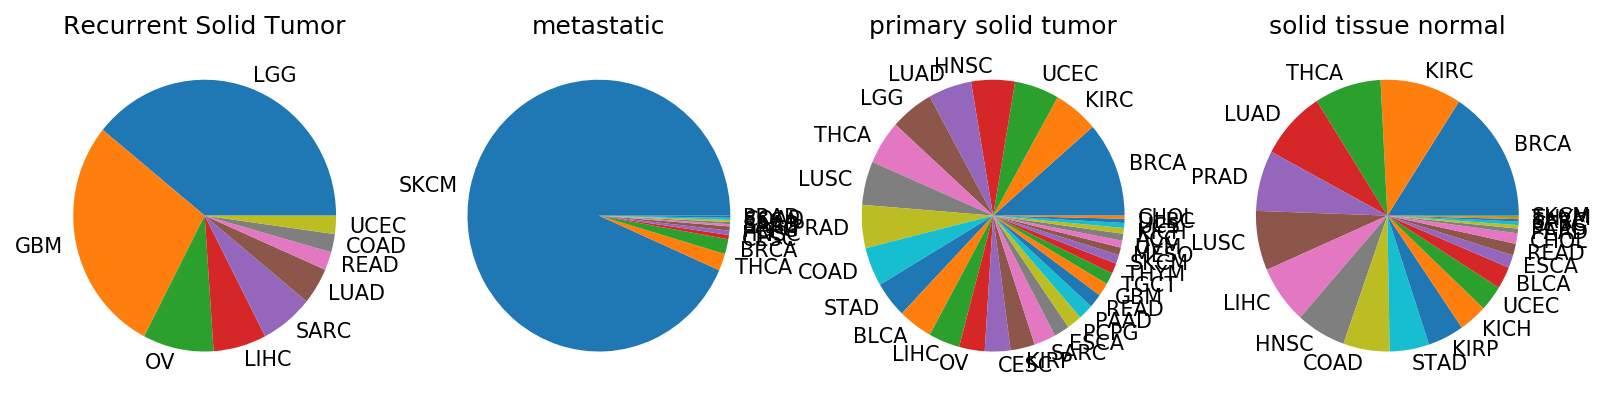

In [5]:
for pie_chart_label in ["label_gender", "label_tissue"]:
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(13,3), dpi=150)
    for i, tumor_type in enumerate(set(label_df.label_tumor)):
        this_tumor = label_df[label_df.label_tumor==tumor_type].copy()
        ax = this_tumor[pie_chart_label].value_counts(normalize=True).plot.pie(ax=axes[i])
        axes[i].set_ylabel("")
        axes[i].set_title(tumor_type)
    plt.show()

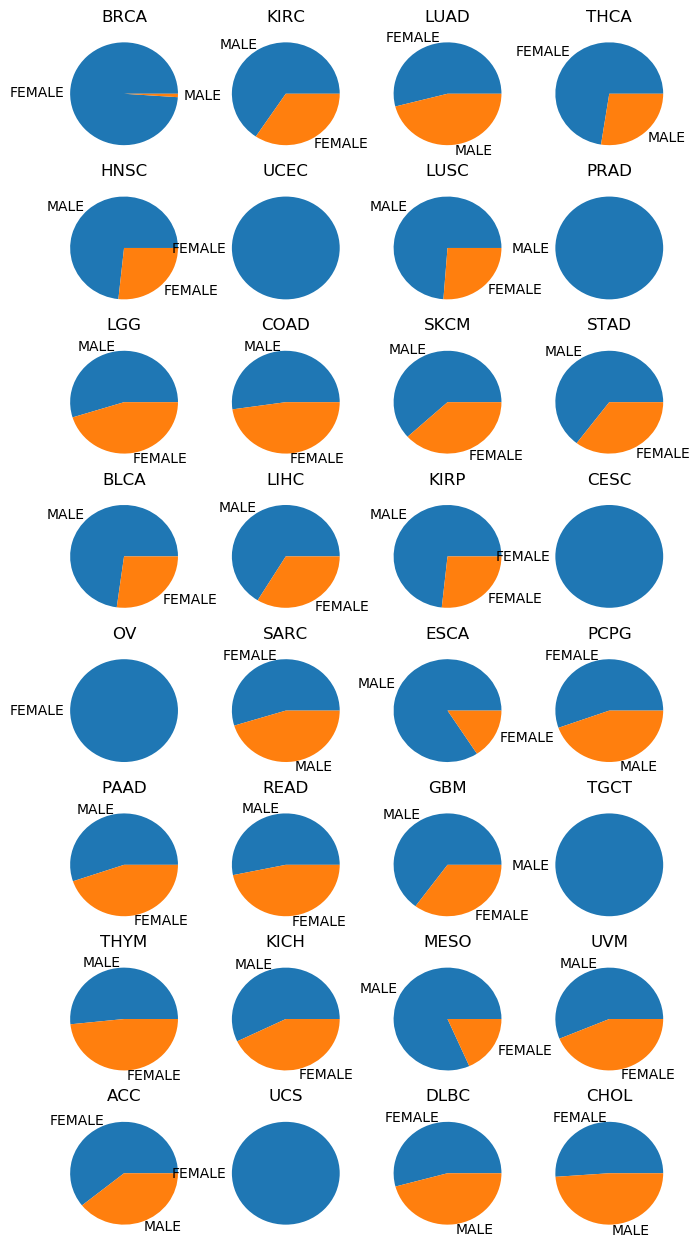

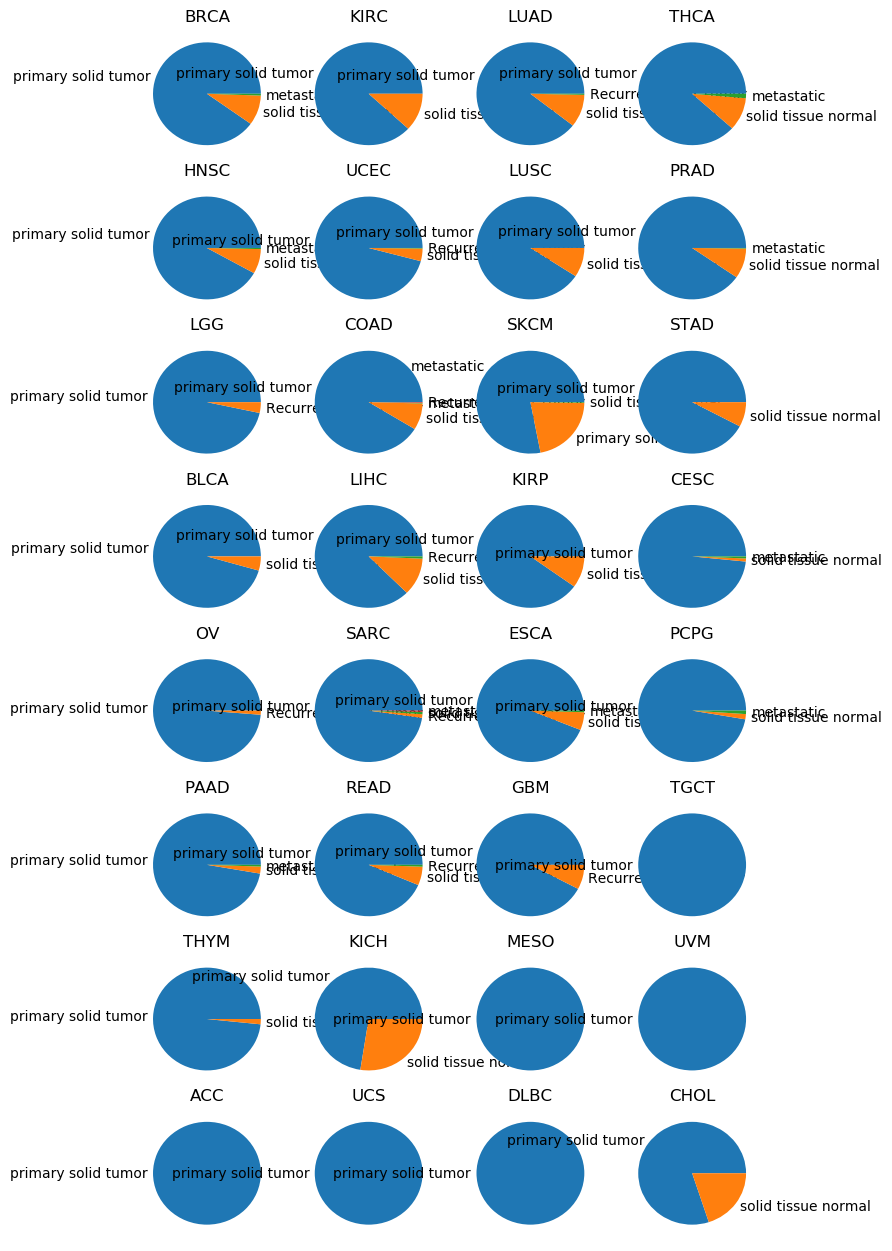

In [21]:
for pie_chart_label in ["label_gender", "label_tumor"]:
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(8, 16), dpi=100)
    for i, tissue_type in enumerate(label_df.label_tissue.value_counts().index):
        row = i // 4
        col = i % 4
        this_tissue = label_df[label_df.label_tissue==tissue_type].copy()
        this_tissue[pie_chart_label].value_counts(normalize=True).plot.pie(ax=axes[row][col])
        axes[row][col].set_ylabel("")
        axes[row][col].set_title(tissue_type)
    plt.show()

### get the number of samples in each one of the tumor \* tissue \* gender combination (4 \* 32 \* 2 = 256)

In [132]:
multi_label_count = label_df.groupby(["label_tumor", "label_tissue", "label_gender"]).count()

In [114]:
multi_label_count

sample_id
label_tumor           label_tissue label_gender           
Recurrent Solid Tumor COAD         FEMALE                1
                      GBM          FEMALE                5
                                   MALE                  8
                      LGG          FEMALE               11
                                   MALE                  7
                      LIHC         MALE                  3
                      LUAD         MALE                  2
                      OV           FEMALE                4
                      READ         MALE                  1
                      SARC         FEMALE                3
                      UCEC         FEMALE                1
metastatic            BRCA         FEMALE                7
                      CESC         FEMALE                2
                      COAD         FEMALE                1
                      ESCA         MALE                  1
                      HNSC         FEMALE                1
                                   MALE                  1
                      PAAD         MALE                  1
                      PCPG         MALE                  2
                      PRAD         MALE                  1
                      SARC         MALE                  1
                      SKCM         FEMALE              139
                                   MALE                230
                      THCA         FEMALE                4
                                   MALE                  4
primary solid tumor   ACC          FEMALE               48
                                   MALE                 31
                      BLCA         FEMALE              107
                                   MALE                301
                      BRCA         FEMALE             1085
...                                                    ...
solid tissue normal   HNSC         FEMALE               14
                                   MALE                 30
                      KICH         FEMALE               12
                                   MALE                 13
                      KIRC         FEMALE               20
                                   MALE                 52
                      KIRP         FEMALE               10
                                   MALE                 22
                      LIHC         FEMALE               22
                                   MALE                 28
                      LUAD         FEMALE               34
                                   MALE                 25
                      LUSC         FEMALE               14
                                   MALE                 37
                      PAAD         FEMALE                2
                                   MALE                  2
                      PCPG         FEMALE                1
                                   MALE                  2
                      PRAD         MALE                 52
                      READ         FEMALE                7
                                   MALE                  3
                      SARC         FEMALE                1
                                   MALE                  1
                      SKCM         MALE                  1
                      STAD         FEMALE               12
                                   MALE                 23
                      THCA         FEMALE               42
                                   MALE                 17
                      THYM         FEMALE                2
                      UCEC         FEMALE               22

[124 rows x 1 columns]

### get rid of (metastatic and recurrent solid tumor) so that tumor \* tissue \* gender combination (2 \* 32 \* 2 = 128)

In [138]:
label_df_binary_tumor = label_df[label_df.label_tumor.isin(['primary solid tumor','solid tissue normal'])]
multi_label_count = label_df_binary_tumor.groupby(["label_tumor", "label_tissue"]).count()["sample_id"]

In [139]:
multi_label_count

label_tumor          label_tissue
primary solid tumor  ACC               79
                     BLCA             408
                     BRCA            1097
                     CESC             305
                     CHOL              36
                     COAD             449
                     DLBC              48
                     ESCA             184
                     GBM              155
                     HNSC             520
                     KICH              66
                     KIRC             533
                     KIRP             290
                     LGG              515
                     LIHC             371
                     LUAD             515
                     LUSC             502
                     MESO              87
                     OV               305
                     PAAD             178
                     PCPG             179
                     PRAD             497
                     READ             160


### Split method:

#### 1. Train + validation vs test split:
* For tumor+tissue combinations that have >=20 samples, randomly take 5% to be included in the test set
* For tumor + tissue combinations that have <20 but >=3 samples, take 1 sample to be included in the test set
* For tumor + tissue combinations that have < 3 samples, take None for the test set

#### 2. Train vs validation split:
* For tumor + tissue combintions with only 1 samples, always include that sample in training
* For tumor + tissue combinations with >2 but <5 samples, randomly pick one to put in validation, put the rest in training
* For tumor + tissue combinations with >=5 samples, split 5-fold for cross validation